# 01.01 EDA y Modelo Inicial
Este programa muestra como cargar un archivo, hacer un mínimo tratamiento y exploración de datos. Plantea algunas reglas de clasificación básica y evalúa los resultados.

In [1]:
#Se limpia la memoria
rm(list=ls())
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,542091,29.0,1171670,62.6,701358,37.5
Vcells,1010336,7.8,8388608,64.0,1753957,13.4


In [2]:
#La librería data table permite manejar grandes volumenes de datos en memoria
library("data.table")

#Contiene funciones para evaluar performance de la clasificación
library("ROCR")

#Permite generar graficos y visualizaciones
library(ggplot2)

Warning message:
“package ‘data.table’ was built under R version 3.6.1”
Warning message:
“package ‘ROCR’ was built under R version 3.6.3”


In [3]:
#Parametros entrada

kcarpeta_datasets    <- "~/buckets/b1/datasets/"

#Archivo con datos etiquetados para entrenamiento
karchivo_entrada      <-  paste0(kcarpeta_datasets, "paquete_premium_202011.csv")

#Archivo con datos sin etiquetar para generar la predicción
karchivo_predecir      <-  paste0(kcarpeta_datasets, "paquete_premium_202101.csv")

#Formato para submit en Kaggle
#karchivo_score      <-  "../input/uamds2020ldi1f1/Sample_201910_Fase_I.txt"

#Separador de campos en archivos
kcampos_separador     <-  "\t"

#Campo que identifica las muestras
kcampo_id             <-  "numero_de_cliente"

#Campo que contiene la clase a estimar
kclase_nomcampo       <-  "clase_ternaria"

#Valor de interés
kclase_valor_positivo <-  "BAJA+2"

#Campos a borrar para el entrenamiento
kcampos_a_borrar      <-  c(kcampo_id,kclase_nomcampo,"foto_mes")

#Campo que contendrá a la variable objetivo generada
kobjetivo             <-  "clase"

#Identificación del modelo
kmodelo               <-  "01-EDA"

#Ganancia por TP
kTPGain               <-  48750

#Pérdida por FP
kFPGain               <-  -1250


## Lectura y manejo básico de datos

In [4]:
#Lectura de archivo de en un data frame
dataset <- fread(karchivo_entrada)

### Estadísticas básicas del dataset

In [5]:
summary(dataset[,1:10]) #Primeras 10 columnas

 numero_de_cliente     foto_mes      active_quarter    cliente_vip      
 Min.   : 4572266   Min.   :202011   Min.   :0.0000   Min.   :0.000000  
 1st Qu.:15702390   1st Qu.:202011   1st Qu.:1.0000   1st Qu.:0.000000  
 Median :24489740   Median :202011   Median :1.0000   Median :0.000000  
 Mean   :26083688   Mean   :202011   Mean   :0.9825   Mean   :0.005042  
 3rd Qu.:35648699   3rd Qu.:202011   3rd Qu.:1.0000   3rd Qu.:0.000000  
 Max.   :61446672   Max.   :202011   Max.   :1.0000   Max.   :1.000000  
    internet        cliente_edad    cliente_antiguedad mrentabilidad    
 Min.   :0.00000   Min.   : 18.00   Min.   :  1.0      Min.   :-258661  
 1st Qu.:0.00000   1st Qu.: 37.00   1st Qu.: 60.0      1st Qu.:     24  
 Median :0.00000   Median : 45.00   Median :123.0      Median :   1017  
 Mean   :0.03678   Mean   : 46.56   Mean   :131.5      Mean   :   1917  
 3rd Qu.:0.00000   3rd Qu.: 55.00   3rd Qu.:185.0      3rd Qu.:   2539  
 Max.   :4.00000   Max.   :104.00   Max.   :477.0  

In [6]:
#El universo agrupado por  clase_ternaria
ftable(dataset$clase_ternaria)

 BAJA+1 BAJA+2 CONTINUA
                       
    767    975   236866

# Selección de datos
Los data frames pueden filtrarse especificando entre corchetes las filas y columnas [filas,columnas]. Las formas de especificar mas usadas son:
- Índice numérico, por ejemplo, *1:10* indica del elemento 1 al 10 (inclusive)
- Nombre o lista de nombres, por ejemplo, *campo*
- Lista de valores Verdadero/Falso. Es utilizadon con condiciones del tipo *columna == valor*


In [7]:
#Seleccionar 3 primeras filas y campos indicados. La función c() genera una lista de valores
dataset[1:3,c("Master_mconsumototal","clase_ternaria")]

Master_mconsumototal,clase_ternaria
<dbl>,<chr>
NA,CONTINUA
57112.78,CONTINUA
NA,CONTINUA


In [8]:
dataset[1:5,c(1:5,155)]

numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,Visa_mconsumototal
<int>,<int>,<int>,<int>,<int>,<dbl>
4572266,202011,1,0,0,NA
4572285,202011,1,0,0,14024.82
4572379,202011,1,0,0,9679.35
4572571,202011,1,0,0,7220.38
4572624,202011,1,0,0,33959.27


In [9]:
#Seleccion por un campo indirecto. kclase_nomcampo es una variable que tiene el nombre del campo. 
dataset[1:3,..kclase_nomcampo]

clase_ternaria
<chr>
CONTINUA
CONTINUA
CONTINUA


Para seleccionar en base a una condicion se arma una lista con Verdadero/Falso actuando como flitro de línea. La siguiente lista adopata el valor Verdadero para las líneas BAJA+2

In [10]:
c(dataset[,..kclase_nomcampo] == kclase_valor_positivo)

[1] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [13] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [25] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [37] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [49] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [61] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [73] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [85] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [97] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [109] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [121] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [133] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [145] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [157] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [169] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [181] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [193] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [205] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [217] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [229] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [241] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [253] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [265] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [277] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [289] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [301] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [313] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [325] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [337] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [349] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [361] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [373] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [385] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [397] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [409] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [421] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [433] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [445] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [457] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [469] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [481] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [493] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [505] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [517] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [529] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [541] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [553] FALSE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [565] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [577] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [589] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [6

Pasando el filtro como condición de línea al data frame se pueden seleccionar solo las que cumplen con la condición

In [11]:
dataset[c(dataset[,..kclase_nomcampo] == kclase_valor_positivo),][1:10]

numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,⋯,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo,clase_ternaria
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<chr>
4645163,202011,1,0,0,53,100,-138.21,-7753.04,276.95,⋯,26,23634.00,-23848.34,0,3053,14433.91,6,0,877.5,BAJA+2
4657723,202011,1,0,0,65,211,1267.30,99129.26,1201.22,⋯,5,0.00,NA,NA,258,NA,NA,NA,0.0,BAJA+2
4671455,202011,1,0,0,62,284,1020.01,20942.70,1026.30,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,BAJA+2
4728522,202011,0,0,0,65,2,328.14,373.41,-159.75,⋯,5,0.00,NA,NA,53,NA,NA,NA,0.0,BAJA+2
4777173,202011,1,0,0,40,167,1382.00,12631.55,1293.49,⋯,5,0.00,-1198.16,0,4460,2148.82,2,0,175.5,BAJA+2
4820455,202011,1,0,0,60,116,1426.76,10003.79,958.70,⋯,12,5226.23,-4885.37,0,3492,1124.12,1,0,456.3,BAJA+2
4876981,202011,1,0,0,55,204,493.20,3729.85,379.79,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,BAJA+2
4923546,202011,1,0,0,54,289,-3769.02,-494.40,317.59,⋯,5,0.00,0.00,0,8797,27574.67,6,0,0.0,BAJA+2
4929415,202011,1,0,0,89,318,6274.19,160029.05,1061.81,⋯,5,0.00,-49497.11,0,8782,17377.23,5,0,1790.1,BAJA+2


### Modificación de datos

Puedo asignar valores a una columna del data frame con el operador := En este caso la referencia indirecta debe hacerse entre paréntesis

In [12]:
#Creo una columna con valor constante
dataset[,(kobjetivo) := 0]
#dataset[  , clase:= 0 ]   Es lo mismo! kobjetivo se definio igual al string "clase"

Asigno 1 en caso de BAJA+2 y 0 para cualquier otro valor.

In [13]:
#clase
dataset[ clase_ternaria=='BAJA+2' ,   clase:= 1]
sum( dataset$clase )

[1] 975

Puedo eliminar columnas asignandoles el valor NULL

In [14]:
#Borro una o varias columnas
#dataset[ ,  (kcampos_a_borrar) := NULL    ] 

In [15]:
#calculo la ganancia de incentivar cada caso
dataset[  , ganancia:= -1250 ]
dataset[ clase_ternaria=='BAJA+2' ,   ganancia:= 48750]
sum( dataset$ganancia )

[1] -249510000

Puedo asignar valores a un dataset "filtrado". En este caso imputo 0 en los NA

In [16]:
#Puedo asignar valores a cualquier campo que cumpla con una condici. Ejemplo valores NA
dataset[is.na(dataset)] <- 0

# Resumen básico del dataset
summary( dataset)

 numero_de_cliente     foto_mes      active_quarter    cliente_vip      
 Min.   : 4572266   Min.   :202011   Min.   :0.0000   Min.   :0.000000  
 1st Qu.:15702390   1st Qu.:202011   1st Qu.:1.0000   1st Qu.:0.000000  
 Median :24489740   Median :202011   Median :1.0000   Median :0.000000  
 Mean   :26083688   Mean   :202011   Mean   :0.9825   Mean   :0.005042  
 3rd Qu.:35648699   3rd Qu.:202011   3rd Qu.:1.0000   3rd Qu.:0.000000  
 Max.   :61446672   Max.   :202011   Max.   :1.0000   Max.   :1.000000  
    internet        cliente_edad    cliente_antiguedad mrentabilidad    
 Min.   :0.00000   Min.   : 18.00   Min.   :  1.0      Min.   :-258661  
 1st Qu.:0.00000   1st Qu.: 37.00   1st Qu.: 60.0      1st Qu.:     24  
 Median :0.00000   Median : 45.00   Median :123.0      Median :   1017  
 Mean   :0.03678   Mean   : 46.56   Mean   :131.5      Mean   :   1917  
 3rd Qu.:0.00000   3rd Qu.: 55.00   3rd Qu.:185.0      3rd Qu.:   2539  
 Max.   :4.00000   Max.   :104.00   Max.   :477.0  

In [17]:
#Resumen segregado por clase ternaria
by(dataset, dataset$clase_ternaria, summary)

dataset$clase_ternaria: BAJA+1
 numero_de_cliente     foto_mes      active_quarter    cliente_vip      
 Min.   : 4613977   Min.   :202011   Min.   :0.0000   Min.   :0.000000  
 1st Qu.:15456742   1st Qu.:202011   1st Qu.:1.0000   1st Qu.:0.000000  
 Median :26499706   Median :202011   Median :1.0000   Median :0.000000  
 Mean   :27371183   Mean   :202011   Mean   :0.8018   Mean   :0.002608  
 3rd Qu.:37981736   3rd Qu.:202011   3rd Qu.:1.0000   3rd Qu.:0.000000  
 Max.   :60474864   Max.   :202011   Max.   :1.0000   Max.   :1.000000  
    internet        cliente_edad   cliente_antiguedad mrentabilidad      
 Min.   :0.00000   Min.   :22.00   Min.   :  1.0      Min.   :-27676.71  
 1st Qu.:0.00000   1st Qu.:37.00   1st Qu.: 39.0      1st Qu.:    76.42  
 Median :0.00000   Median :47.00   Median : 87.0      Median :  1026.20  
 Mean   :0.09909   Mean   :48.75   Mean   :110.1      Mean   :  1338.50  
 3rd Qu.:0.00000   3rd Qu.:60.00   3rd Qu.:161.0      3rd Qu.:  1734.77  
 Max.   :2.000

## EDA


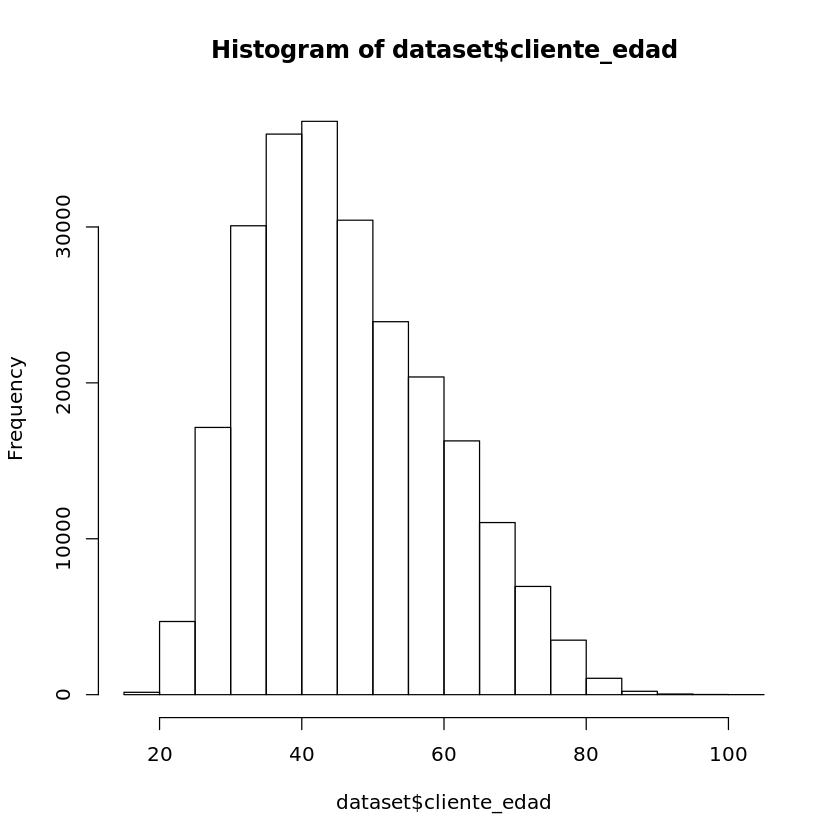

In [18]:
hist(dataset$cliente_edad)

In [19]:
#Puedo aprovechar esa diferencia???
ftable(dataset[ cliente_edad <=33, clase])

     0     1
            
 38878   160

In [20]:
ftable(dataset[ cliente_edad  >33, clase])

      0      1
              
 198755    815

In [21]:
#Ganancia
sum( dataset[ cliente_edad <=33, ganancia] )

[1] -40797500

In [22]:
#Lift
(sum( dataset[ cliente_edad <=33, clase]) / nrow( dataset[ cliente_edad <=33, ] )) /  (sum( dataset[, clase]) / nrow( dataset ))

[1] 1.003027

In [23]:
#Ganancia
sum( dataset[ cliente_edad >33, ganancia] )


[1] -208712500

In [24]:
#Lift
(sum( dataset[ cliente_edad >33, clase]) / nrow( dataset[ cliente_edad >33, ] )) /  (sum( dataset[, clase]) / nrow( dataset ))

[1] 0.9994078

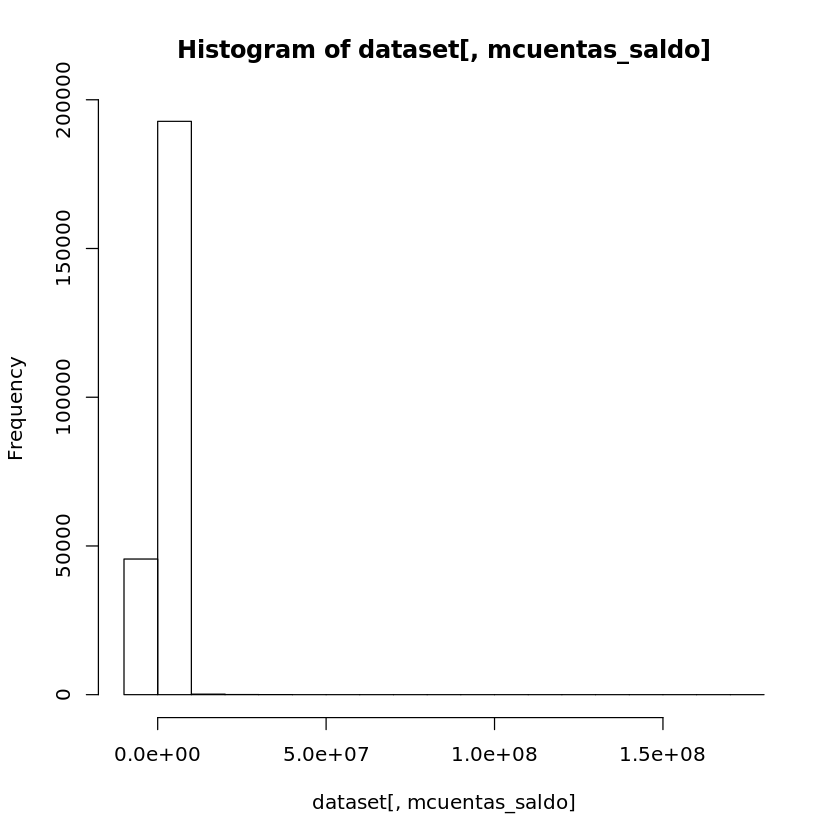

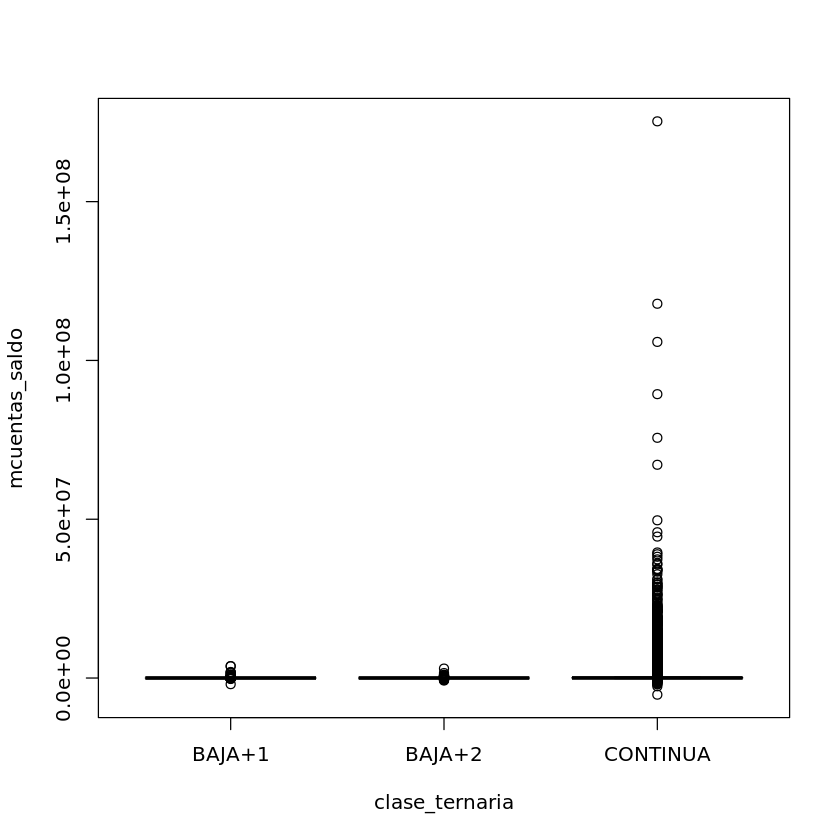

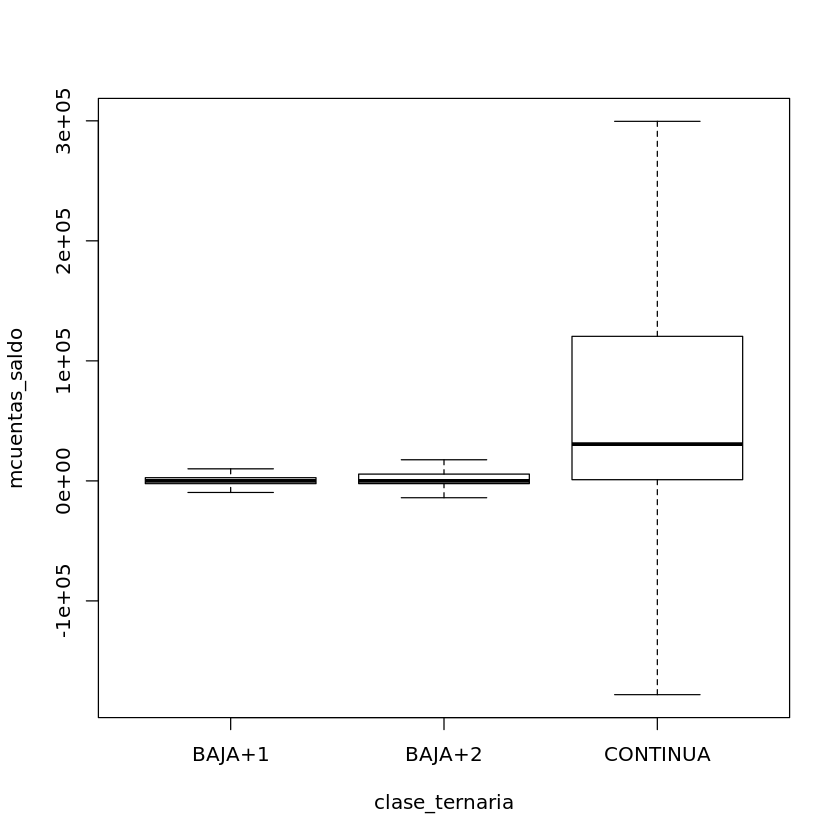

In [25]:
#Corte por mcuentas_saldo
hist(dataset[ ,mcuentas_saldo] )
boxplot(mcuentas_saldo  ~ clase_ternaria, data=dataset)
boxplot(mcuentas_saldo  ~ clase_ternaria, data=dataset, outline=FALSE)

In [26]:
ftable(dataset[ mcuentas_saldo <= -120000, clase_ternaria])

 BAJA+1 BAJA+2 CONTINUA
                       
      2      9      232

In [27]:
ftable(dataset[ mcuentas_saldo >  -120000, clase_ternaria])

 BAJA+1 BAJA+2 CONTINUA
                       
    765    966   236634

In [28]:
sum( dataset[ mcuentas_saldo <= -120000, ganancia] )

[1] 146250

In [29]:
sum( dataset[ mcuentas_saldo > -120000, ganancia] )

[1] -249656250

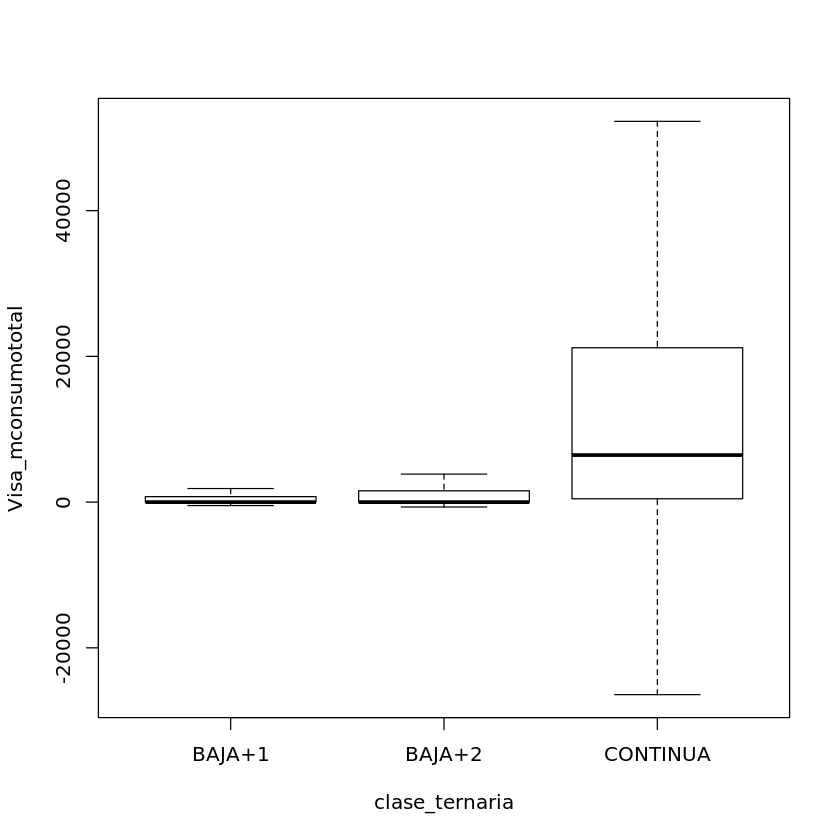

In [30]:
boxplot(Visa_mconsumototal  ~ clase_ternaria, data=dataset, outline=FALSE)

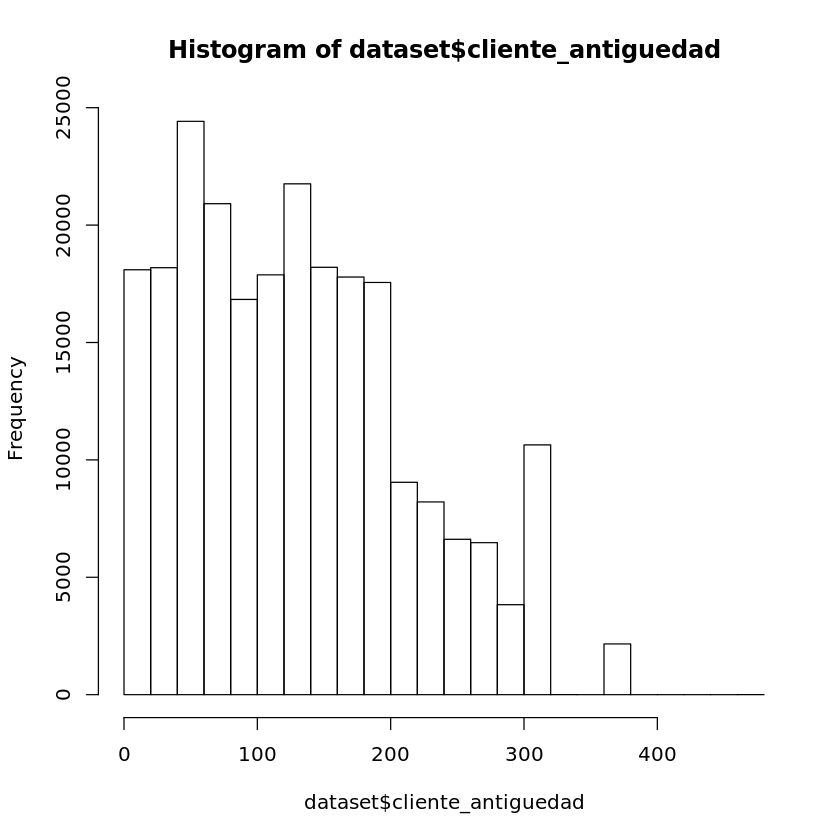

In [31]:
hist(dataset$cliente_antiguedad)

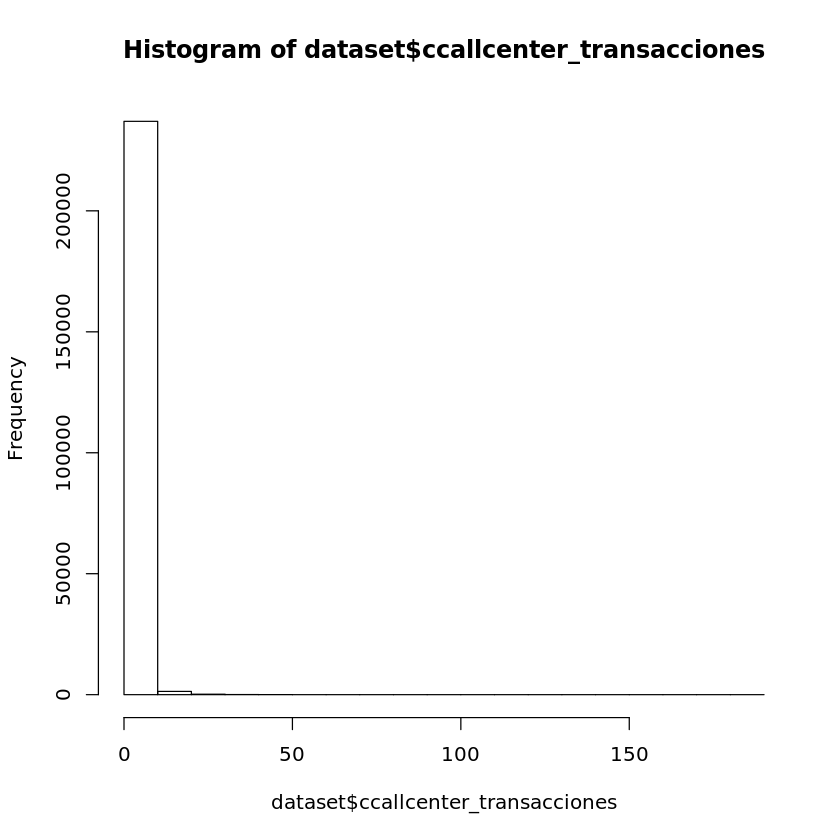

In [32]:
hist(dataset$ccallcenter_transacciones)

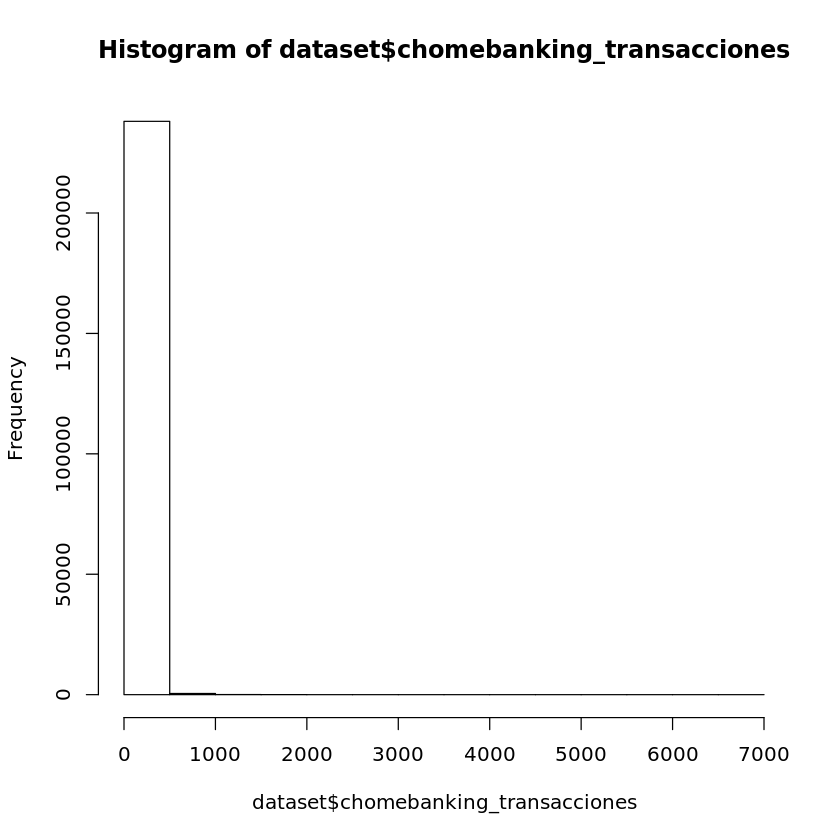

In [33]:
hist(dataset$chomebanking_transacciones)

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


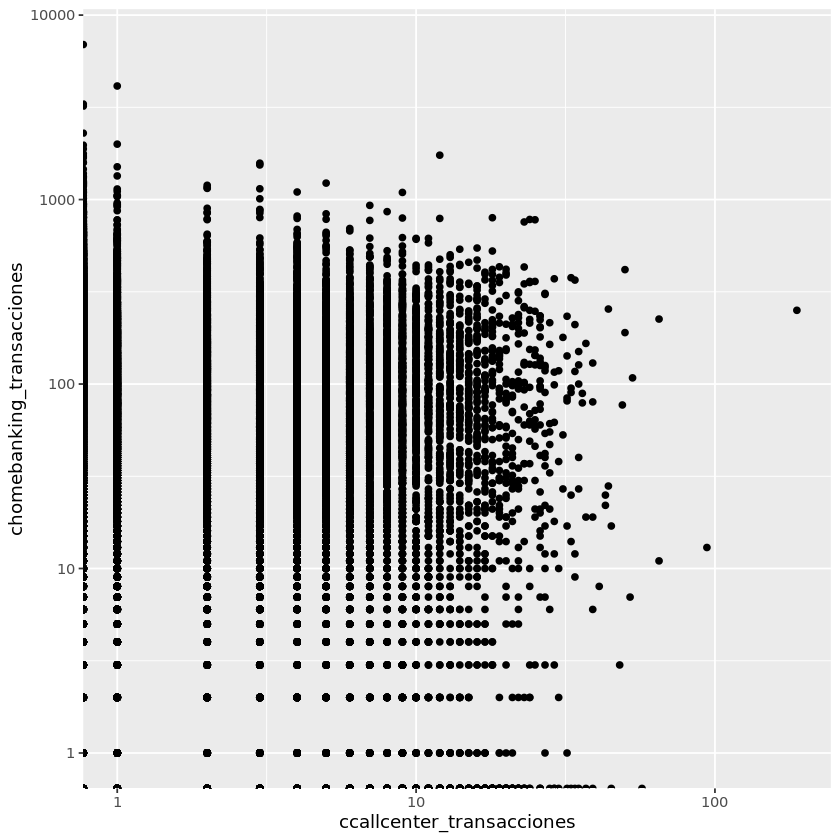

In [34]:
ggplot(dataset, aes(x=ccallcenter_transacciones, y=chomebanking_transacciones)) + # fill=name allow to automatically dedicate a color for each group
        geom_point()+
        scale_x_log10()+
        scale_y_log10()


Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 54279 rows containing non-finite values (stat_bin).”


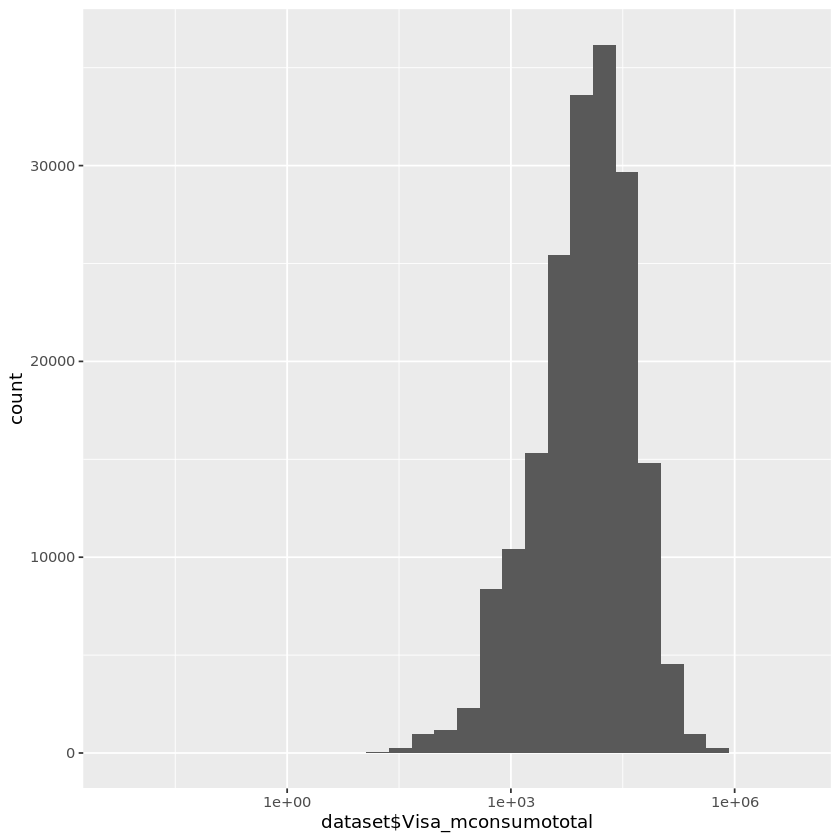

In [35]:
ggplot(dataset, aes(x=dataset$Visa_mconsumototal))+ geom_histogram() + scale_x_log10()

Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 172382 rows containing non-finite values (stat_bin).”


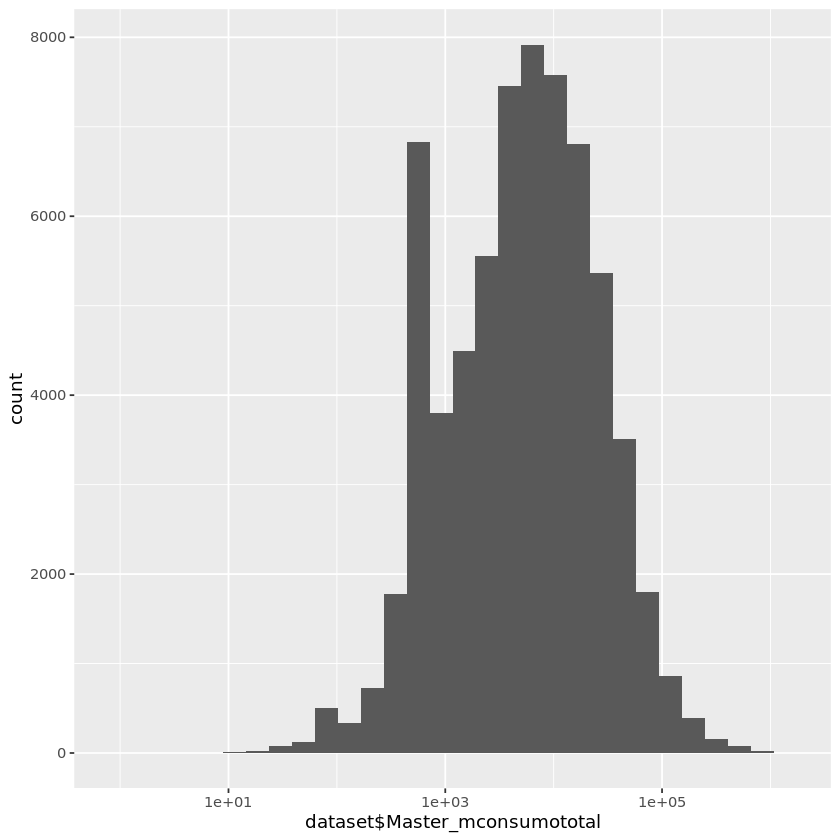

In [36]:
ggplot(dataset, aes(x=dataset$Master_mconsumototal))+ geom_histogram() + scale_x_log10()

Determino correlaciones entre las variables y el objetivo. 

In [37]:
dataset[ ,  (kcampos_a_borrar) := NULL    ] 
correlaciones <- abs(cor(dataset[,-..kobjetivo],dataset[,..kobjetivo]))

In [38]:
correlaciones[order(-correlaciones[,1]),][0:20]

ganancia                    active_quarter 
                       1.00000000                        0.07858033 
                     ctrx_quarter                        cproductos 
                       0.05818516                        0.04709939 
                    ctarjeta_visa       ctarjeta_visa_transacciones 
                       0.04612596                        0.04329742 
                     cpayroll_trx                   ctarjeta_master 
                       0.04113891                        0.04088641 
    ctarjeta_debito_transacciones                 ccomisiones_otras 
                       0.03707168                        0.03699149 
                   Visa_cconsumos ctarjeta_visa_debitos_automaticos 
                       0.03655011                        0.03415617 
                  cmobile_app_trx                     mautoservicio 
                       0.03339017                        0.03097513 
            mtarjeta_visa_consumo                  Visa_mpagospesos 
                       0.03078831                        0.02985885 
        ccomisiones_mantenimiento          cextraccion_autoservicio 
                       0.02959352                        0.02945847 
                     thomebanking          mdescubierto_preacordado 
                       0.02935836                        0.02930695

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 2877 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 2877 rows containing non-finite values (stat_ydensity).”


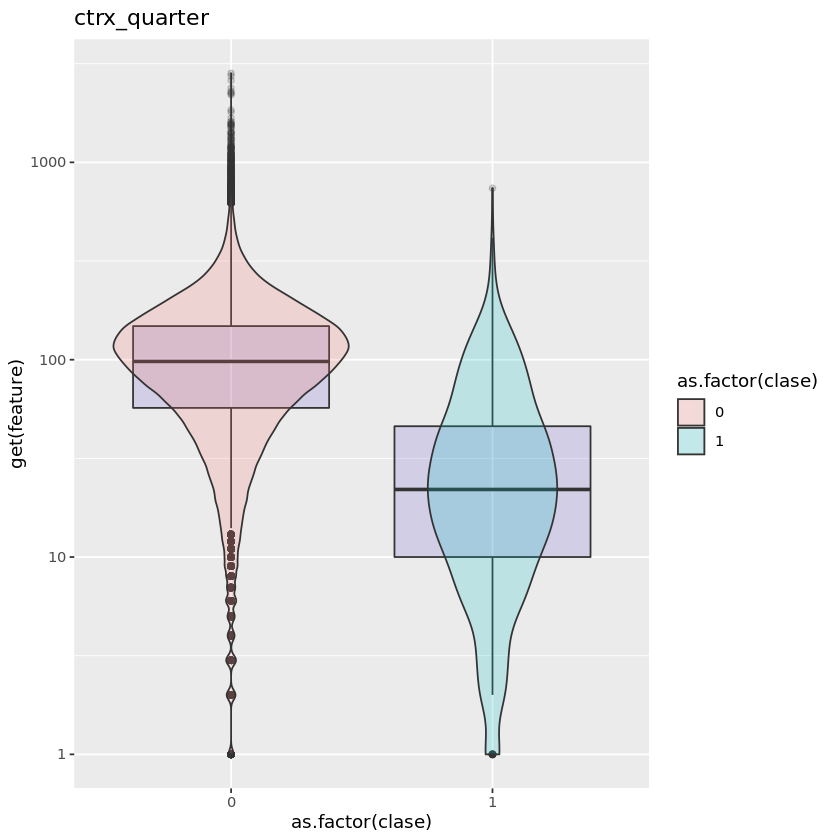

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 36789 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 36789 rows containing non-finite values (stat_ydensity).”


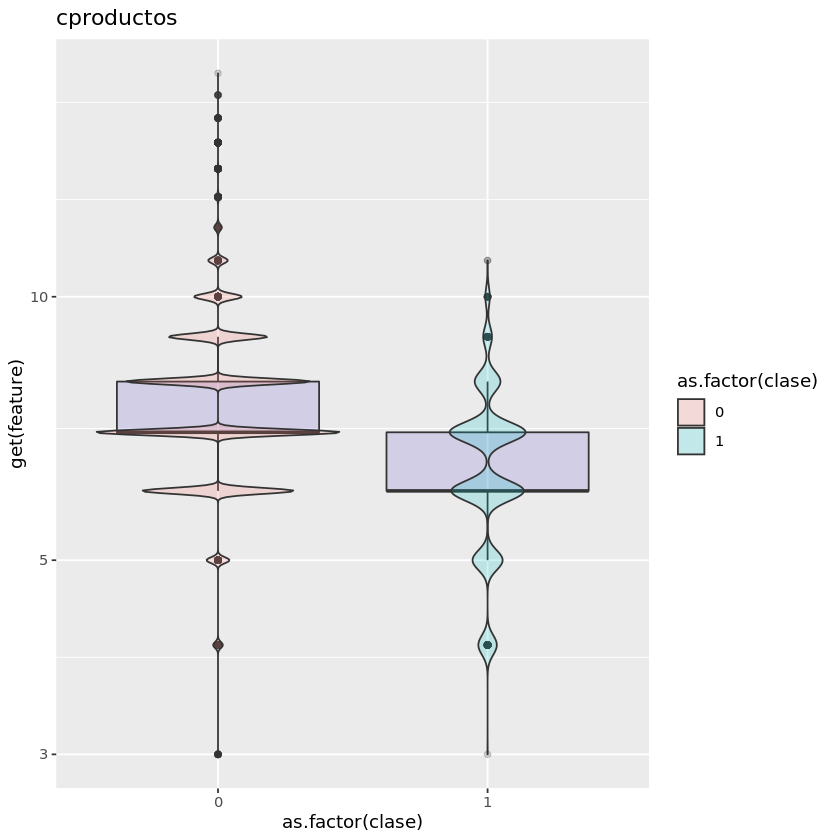

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 52185 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 52185 rows containing non-finite values (stat_ydensity).”


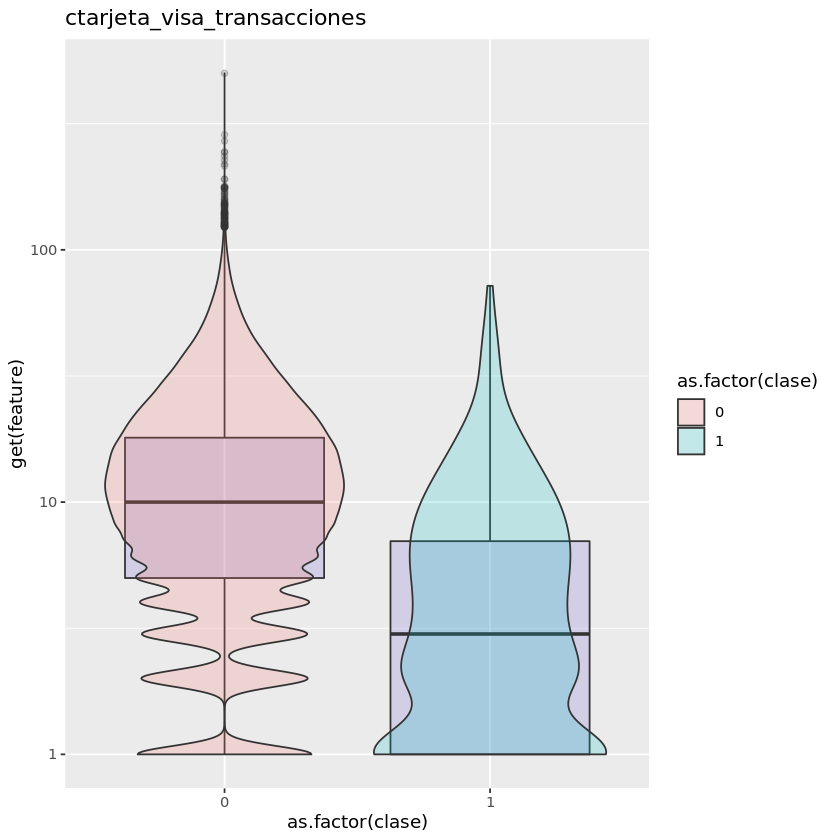

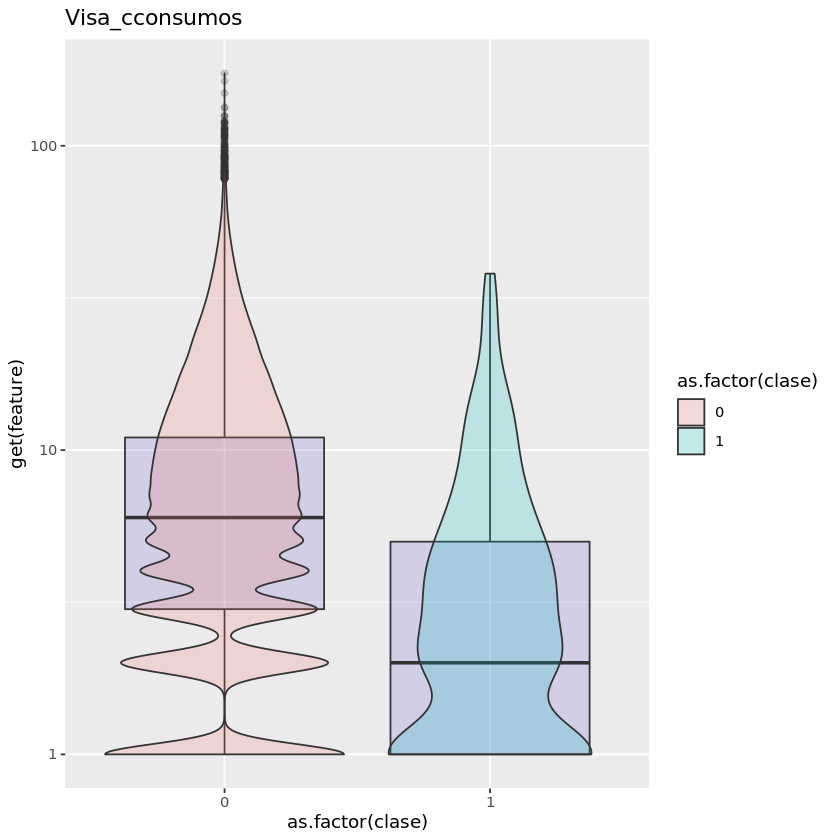

In [39]:
library(ggplot2)

for (feature in names(correlaciones[order(-correlaciones[,1]),][c(3,4,6,11)])) {
    
    
    plot <- ggplot(dataset, aes(x=as.factor(clase), y=get(feature), fill=as.factor(clase))) + # fill=name allow to automatically dedicate a color for each group
      geom_boxplot(fill="slateblue", alpha=0.2)+
      geom_violin(alpha=0.2)+
    ggtitle(feature)+
        scale_y_log10()
    print(plot)
    
}

## Modelo básico
Vamos a definir un modelo muy básico. La gente que no usa las tarjetas de crédito es candidata a darse de baja. Defino una variable como la suma de transacciones en ambas franquicias.

Warning message:
“Removed 38384 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 38384 rows containing non-finite values (stat_ydensity).”


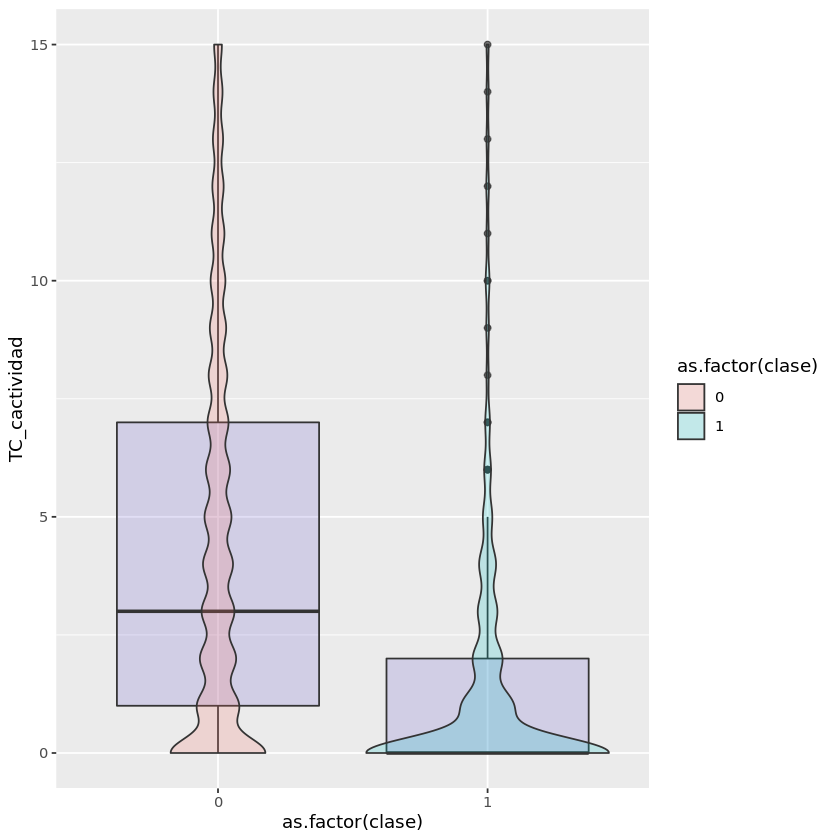

In [40]:
dataset$TC_cactividad = dataset$Visa_cconsumos + dataset$Master_cconsumos 

# Most basic violin chart
ggplot(dataset, aes(x=as.factor(clase), y=TC_cactividad, fill=as.factor(clase))) + # fill=name allow to automatically dedicate a color for each group
  geom_boxplot(fill="slateblue", alpha=0.2)+
  geom_violin(alpha = 0.2)+
     ylim(0, 15)

Genero la variable Predicted con 1 si no tiene movimientos. 

In [41]:
dataset$Predicted = as.integer(dataset$TC_cactividad < 1)

Determino la curva ROC y Área bajo la curva

[[1]]
[1] 0.701016

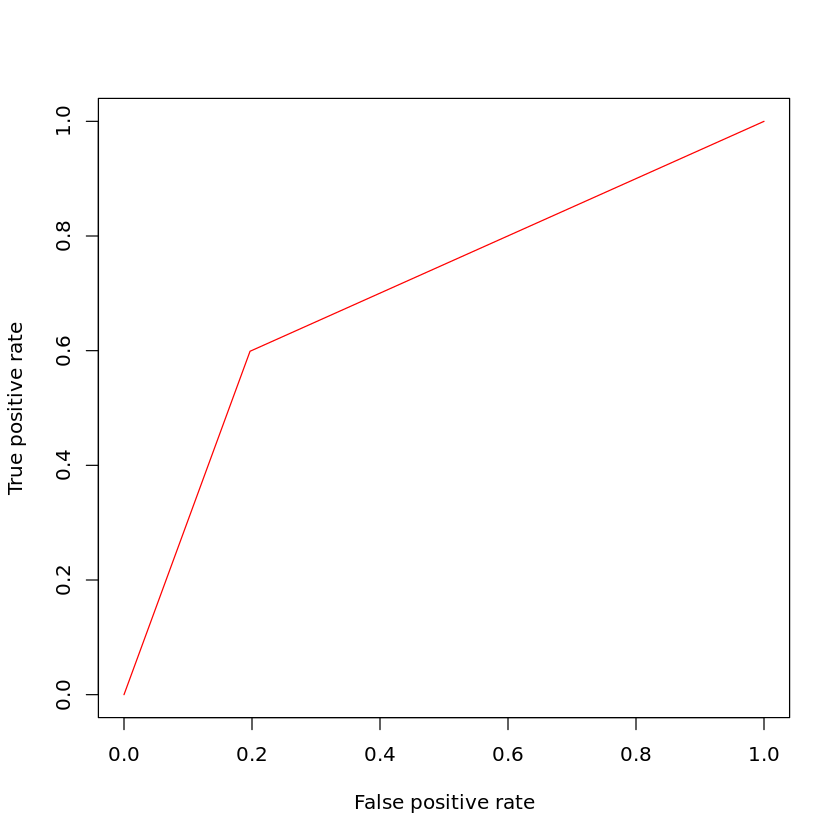

In [42]:
#Calculo las metricas
pred <- prediction(dataset$Predicted, dataset$clase)

#Calculo las metricas
perf <- performance(pred, measure = "tpr", x.measure = "fpr")

#Grafico la ROC
plot(perf, col=rainbow(10))

#Determino AUC
performance( pred,"auc")@y.values


Cuanto dinero vale el modelo para el banco?

In [43]:
#Calculo la ganancia
sum(dataset$Predicted*dataset[,..kobjetivo]*kTPGain + dataset$Predicted * (0 == dataset[,..kobjetivo]) * kFPGain)

[1] -30030000

In [44]:
#TP
sum(dataset$Predicted*dataset[,..kobjetivo])

[1] 584

In [45]:
#Incentivados Totales
sum(dataset$Predicted)

[1] 47384

Corremos el modelo para el dataset del que no conocemos la clase

In [46]:
#Leo Archivo a Predecir
dataset_pred <- fread(karchivo_predecir)

dataset_salida <- dataset_pred[,..kcampo_id]

#Campos a eliminar
dataset_pred[ ,  (kcampos_a_borrar) := NULL    ] 

#Inputo missings
dataset_pred[is.na(dataset_pred)] <- 0

#Identifico casos a incentivar en el modelo definido
dataset_pred$TC_cactividad = dataset_pred$Visa_cconsumos + dataset_pred$Master_cconsumos 
dataset_pred$Predicted = as.integer(dataset_pred$TC_cactividad < 1)

#Grabo prediccion en salida
dataset_salida[,"Predicted"] <- dataset_pred$Predicted
write.csv(dataset_salida,"./salida_basico.csv", row.names = FALSE)

Modelo alternativo con regla mas amplia. Incentivo todos aquellos que tienen menos de tres trx

[[1]]
[1] 0.7190032

[1] "La Ganancia es: -68222500"


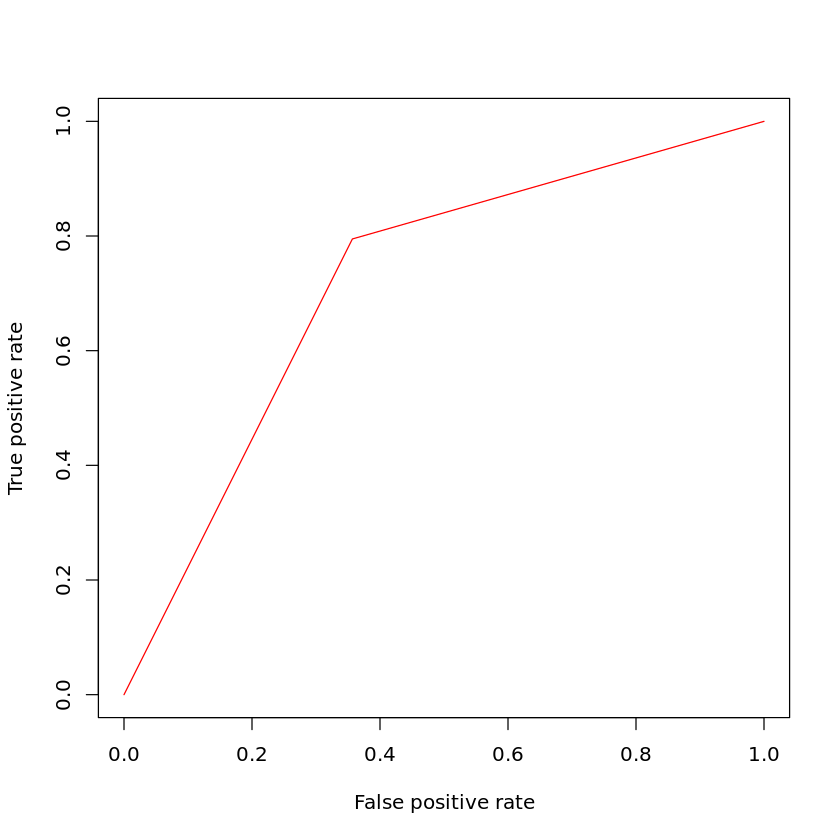

In [47]:
dataset$Predicted = as.integer(dataset$TC_cactividad < 3)
pred <- prediction(dataset$Predicted, dataset$clase)

#Calculo las metricas
perf <- performance(pred, measure = "tpr", x.measure = "fpr")

#Grafico la ROC
plot(perf, col=rainbow(10))

#Determino AUC
performance( pred,"auc")@y.values

#Calculo la ganancia
print(paste("La Ganancia es:", sum(dataset$Predicted*dataset[,..kobjetivo]*kTPGain + dataset$Predicted * (0 == dataset[,..kobjetivo]) * kFPGain)))

In [48]:
#Leo Archivo a Predecir
dataset_pred <- fread(karchivo_predecir)

dataset_salida <- dataset_pred[,..kcampo_id]

#Campos a eliminar
dataset_pred[ ,  (kcampos_a_borrar) := NULL    ] 

#Inputo missings
dataset_pred[is.na(dataset_pred)] <- 0

#Identifico casos a incentivar
dataset_pred$TC_cactividad = dataset_pred$Visa_cconsumos + dataset_pred$Master_cconsumos 
dataset_pred$Predicted = as.integer(dataset_pred$TC_cactividad < 3)

#Grabo prediccion en salida
dataset_salida[,"Predicted"] <- dataset_pred$Predicted
write.csv(dataset_salida,"./salida_basico_3tx.csv", row.names = FALSE)

Modelo alternativo con regla mas estricta. Incentivo todos aquellos que no tienen trx pero si en el trimestre

[[1]]
[1] 0.6515253

[1] "La Ganancia es: -13880000"


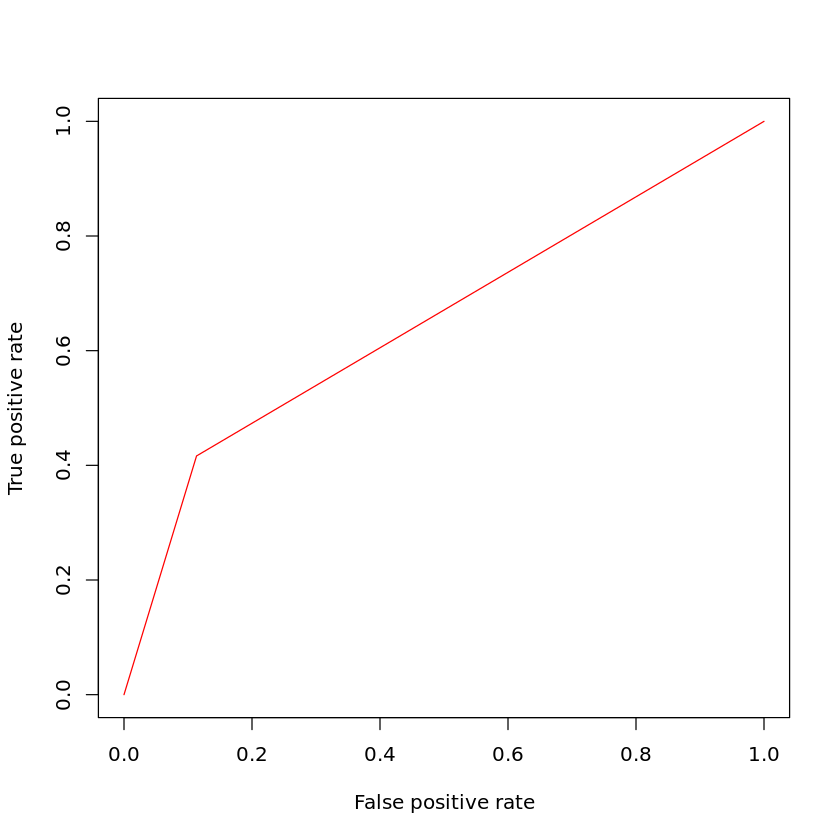

In [49]:
dataset$Predicted = as.integer((dataset$Master_cconsumos == 0) & (dataset$Visa_cconsumos == 0) 
                               & (dataset$catm_trx == 0)
                               & (dataset$ctrx_quarter != 0)
                              )

pred <- prediction(dataset$Predicted, dataset$clase)

perf <- performance(pred, measure = "tpr", x.measure = "fpr")
plot(perf, col=rainbow(10))
performance( pred,"auc")@y.values
print(paste("La Ganancia es:", sum(dataset$Predicted*dataset[,..kobjetivo]*kTPGain + dataset$Predicted * (0 == dataset[,..kobjetivo]) * kFPGain)))

In [50]:
#Leo Archivo a Predecir
dataset_pred <- fread(karchivo_predecir)

dataset_salida <- dataset_pred[,..kcampo_id]

#Campos a eliminar
dataset_pred[ ,  (kcampos_a_borrar) := NULL    ] 

#Inputo missings
dataset_pred[is.na(dataset_pred)] <- 0

#Identifico casos a incentivar
dataset_pred$Predicted = as.integer((dataset_pred$Master_cconsumos == 0) & (dataset_pred$Visa_cconsumos == 0) 
                               & (dataset_pred$catm_trx == 0)
                               & (dataset_pred$ctrx_quarter != 0)
                              )

#Grabo prediccion en salida
dataset_salida[,"Predicted"] <- dataset_pred$Predicted
write.csv(dataset_salida,"./salida_basico_rest.csv", row.names = FALSE)



Modelo alternativo con regla mas estricta. Incentivo todos aquellos que no tienen trx pero si en el trimestre